# Assignment 1 -- Supervised learning

### To run this code you need
* Python 3.x

### and the following packages
* numpy
* pandas
* matplotlib
* scikitlearn
* xgboost

### Dataset urls
* [Dataset 1](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)
* [Dataset 2](https://archive.ics.uci.edu/ml/datasets/adult)
------

# Imports and utility functions

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [244]:
def train_and_get_stats(clf, X_train, Y_train, X_test, Y_test):
    start = time.time()
    clf.fit(X_train, Y_train)
    end = time.time()
    training_time = end - start
    
    start = time.time()
    train_acc = clf.score(X_train, Y_train)
    end = time.time()
    train_score_time = end - start
    
    start = time.time()
    test_acc = clf.score(X_test, Y_test)
    end = time.time()
    test_score_time = end - start
    
    cv_scores_train = cross_val_score(clf, X_train, Y_train, cv=5)
    cv_scores_test = cross_val_score(clf, X_test, Y_test, cv=5)
    
    return {
        'train_time': training_time,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_score_time': train_score_time,
        'test_score_time': test_score_time,
        'cv_scores_train': cv_scores_train,
        'cv_scores_test': cv_scores_test
    }


def plot_training_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, fig_size=(10, 10), train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=fig_size)
    plt.title(title)
    if ylim is not None:
        plt.set_ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Test score")
    plt.legend(loc="best")
    

def plot_validation_curve(clf, param_name, param_range, X_train, Y_train, title='Validation Curve', cv=5, n_jobs=1):
    train_scores, test_scores = validation_curve(
        clf, 
        X_train, 
        Y_train, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv,
        n_jobs=n_jobs, 
        scoring = "accuracy"
    )

    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=20)
    plt.xlabel(param_name, fontsize=15)
    plt.ylabel("Score", fontsize=15)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Test score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# Dataset 1 - Salary class, Data preprocessing

In [287]:
data = pd.read_csv('data/adult.data')
test = pd.read_csv('data/adult.test')

In [348]:
data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,salary-class
0,39,77516,13,2174,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
32557,40,154374,9,0,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
32558,58,151910,9,0,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [290]:
# get discrete class columns from data, and one hot encode
discrete_classes = ['workclass',
                    'education', 
                    'sex',
                    'marital-status',
                    'occupation',
                    'relationship', 
                    'native-country',
                    'race', 
                    'salary-class']
encoded_train = pd.get_dummies(data[discrete_classes])
encoded_test = pd.get_dummies(test[discrete_classes])

# drop old non-encoded columns from data, and add encoded data
data.drop(columns=discrete_classes, inplace=True)
data = pd.concat([data, encoded_train], axis=1)
test.drop(columns=discrete_classes, inplace=True)
test = pd.concat([test, encoded_test], axis=1)

# drop extra output column as 'salary <= 50k' -> 0, and 'salary >50k' -> 1
data.drop(columns=['salary-class_ <=50K'], inplace=True)
data.rename(columns={'salary-class_ >50K': 'salary-class'}, inplace=True)
test.drop(columns=['salary-class_ <=50K'], inplace=True)
test.rename(columns={'salary-class_ >50K': 'salary-class'}, inplace=True)

In [291]:
x_keys = set(data.keys()) - set(['salary-class']) & set(test.keys()) - set(['salary-class'])
y_keys = set(['salary-class'])

X_train = data[x_keys]
X_test = test[x_keys]

Y_train = data[y_keys].to_numpy().ravel()
Y_test = test[y_keys].to_numpy().ravel()

# Experiments

## Decision Tree classifier

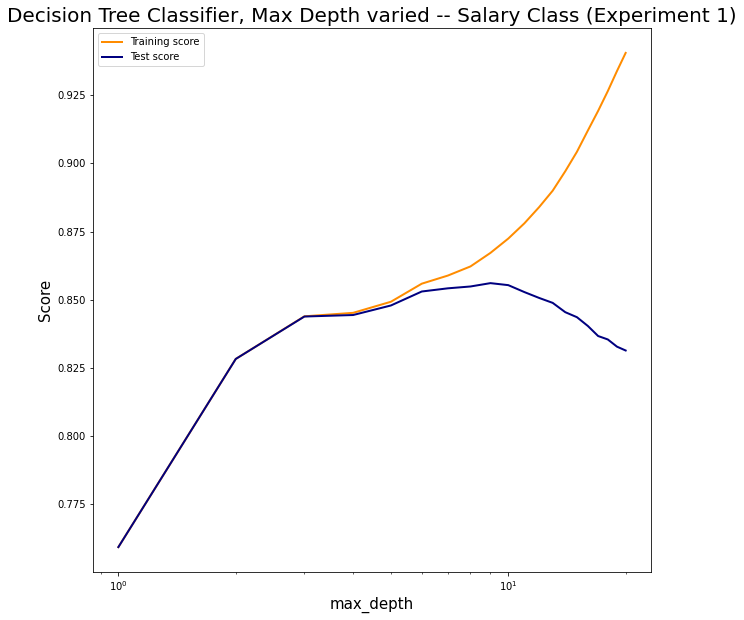

In [266]:
dt_classifier_unpruned = DecisionTreeClassifier(max_depth=None, criterion='gini', splitter='best', random_state=42)
dt1_Unpruned_stats = train_and_get_stats(dt_classifier_unpruned, X_train, Y_train, X_test, Y_test)
print(dt1_Unpruned_stats)

dt_classifier = DecisionTreeClassifier(max_depth=10, criterion='gini', splitter='best', random_state=42)
dt1_stats = train_and_get_stats(dt_classifier, X_train, Y_train, X_test, Y_test)
print(dt1_stats)

plot_training_curve(
    DecisionTreeClassifier(max_depth=10, criterion='gini', splitter='best', random_state=42),
    "Decision Tree Classifier -- Salary Class (Experiment 1)",
    X_train,
    Y_train,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)
plot_validation_curve(
    DecisionTreeClassifier(max_depth = 10, criterion='gini', splitter='best', random_state=42),
    'max_depth',
    list(range(1, 21)),
    X_train,
    Y_train,
    "Decision Tree Classifier, Max Depth varied -- Salary Class (Experiment 1)",
     cv=5,
    n_jobs=18
)

In [ ]:
print(round(dt1_stats['train_acc'], 4) * 100)
print(round(dt1_stats['test_acc'], 4) * 100)

train_sizes = np.linspace(.1, 1.0, 10)
plt.figure(figsize=(10, 10))
plt.title("Decision Tree Classifier -- Salary Class (Experiment 1)")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(dt_classifier, X_train, Y_train, cv=5, n_jobs=18,
                   train_sizes=train_sizes,
                   return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(dt_classifier_unpruned, X_train, Y_train, cv=5, n_jobs=18,
                   train_sizes=train_sizes,
                   return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="y")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score (Unpruned)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="y",
             label="Test score (Unpruned)")

plt.legend(loc="best")
plt.show()

## Support Vector Machine classifier

In [11]:
#
# Moved below because this is slow
#

## K Nearest Neighbors classifier

{'train_time': 0.01300048828125, 'train_acc': 0.9999692884125181, 'test_acc': 0.7991523862170629, 'train_score_time': 20.37527060508728, 'test_score_time': 10.115719556808472, 'cv_scores_train': array([0.79302933, 0.79806511, 0.79898649, 0.79791155, 0.79453317]), 'cv_scores_test': array([0.79766656, 0.79791155, 0.78593366, 0.78163391, 0.79330467])}


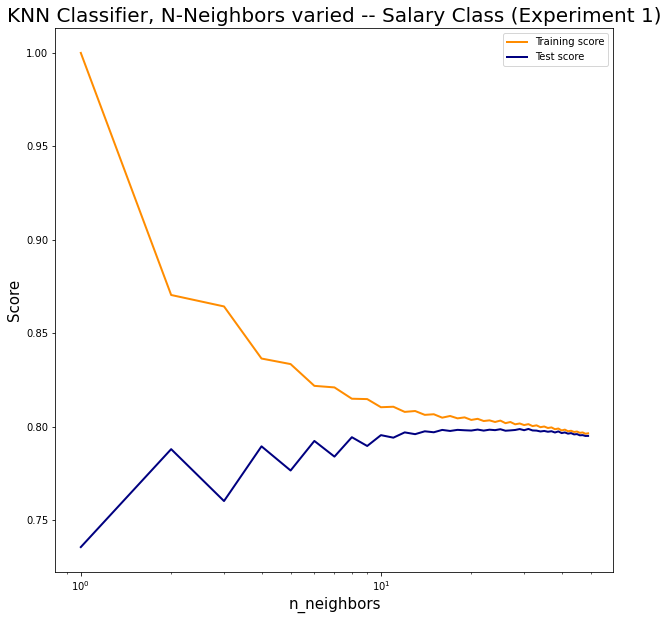

In [276]:
knn_classifier = KNeighborsClassifier(n_neighbors=25, weights='distance', n_jobs=24)
knn1_stats = train_and_get_stats(knn_classifier, X_train, Y_train, X_test, Y_test)

print(knn1_stats)
plot_training_curve(
    KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    "KNN Classifier -- Salary Class (Experiment 1)",
    X_train,
    Y_train,
    cv=5,
    n_jobs=10,
    fig_size=(10, 10)
)
plot_validation_curve(
    KNeighborsClassifier(n_jobs=10),
    'n_neighbors',
    list(range(1, 50)),
    X_train,
    Y_train,
    "KNN Classifier, N-Neighbors varied -- Salary Class (Experiment 1)",
     cv=5,
    n_jobs=18
)

## Neural Network classifier

{'train_time': 8.596255540847778, 'train_acc': 0.8134578176345936, 'test_acc': 0.8146919722375775, 'train_score_time': 0.018999576568603516, 'test_score_time': 0.010000944137573242, 'cv_scores_train': array([0.79364348, 0.79299754, 0.70915233, 0.79806511, 0.78547297]), 'cv_scores_test': array([0.7979736 , 0.79422604, 0.24017199, 0.79514742, 0.78869779])}


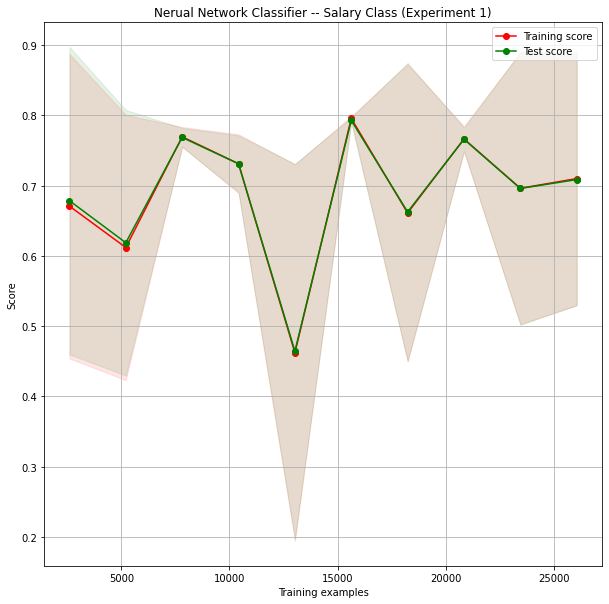

In [312]:
nn_classifier = MLPClassifier(hidden_layer_sizes=(25), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn1_stats = train_and_get_stats(nn_classifier, X_train, Y_train, X_test, Y_test)
print(nn1_stats)

plot_training_curve(
    MLPClassifier(hidden_layer_sizes=(10), activation='relu', solver='adam', alpha=0.0001, random_state=1, learning_rate='adaptive'),
    "Nerual Network Classifier -- Salary Class (Experiment 1)",
    X_train,
    Y_train,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)

## Boosted Decision Trees classifier

c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'train_time': 0.5430047512054443, 'train_acc': 0.8842480267805043, 'test_acc': 0.8751919415269332, 'train_score_time': 0.023996353149414062, 'test_score_time': 0.013000249862670898, 'cv_scores_train': array([0.86903117, 0.86901106, 0.87300369, 0.87699631, 0.8737715 ]), 'cv_scores_test': array([0.86245011, 0.87162162, 0.86302211, 0.872543  , 0.87714988])}


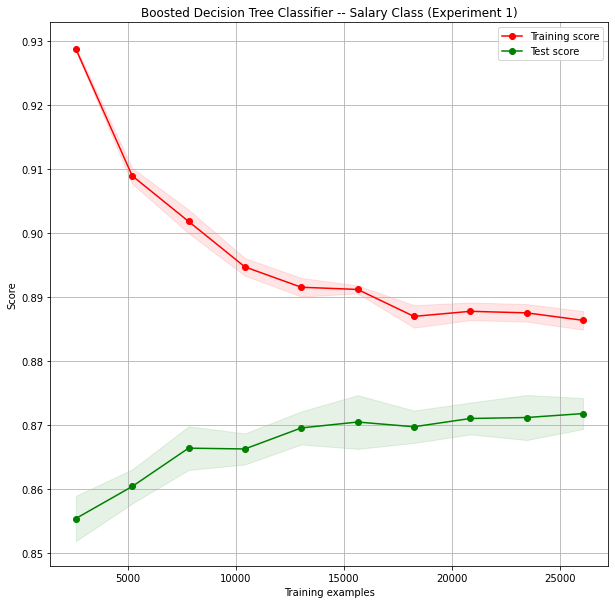

In [339]:
clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=42)
clf1_stats = train_and_get_stats(clf, X_train, Y_train, X_test, Y_test)

print(clf1_stats)
plot_training_curve(
    xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=42),
    "Boosted Decision Tree Classifier -- Salary Class (Experiment 1)",
    X_train,
    Y_train,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)

# Dataset 2 -- Credit defaults, Data Preprocessing

In [349]:
data2 = pd.read_csv('data/UCI_Credit_Card.csv')
target_column = ['default.payment.next.month']

In [350]:
data2

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [351]:
data2.loc[(data2.SEX == 1), 'SEX'] = 'male'
data2.loc[(data2.SEX == 2), 'SEX'] = 'female'

data2.drop(index=data2.index[data2['EDUCATION'] == 0], inplace=True)
data2.loc[(data2.EDUCATION == 1), 'EDUCATION'] = 'graduate school'
data2.loc[(data2.EDUCATION == 2), 'EDUCATION'] = 'university'
data2.loc[(data2.EDUCATION == 3), 'EDUCATION'] = 'high school'
data2.loc[(data2.EDUCATION == 4), 'EDUCATION'] = 'others'
data2.loc[(data2.EDUCATION == 5), 'EDUCATION'] = 'unknown'
data2.loc[(data2.EDUCATION == 6), 'EDUCATION'] = 'unknown'

data2.drop(index=data2.index[data2['MARRIAGE'] == 0], inplace=True)
data2.loc[(data2.MARRIAGE == 1), 'MARRIAGE'] = 'married'
data2.loc[(data2.MARRIAGE == 1), 'MARRIAGE'] = 'married'
data2.loc[(data2.MARRIAGE == 2), 'MARRIAGE'] = 'single'
data2.loc[(data2.MARRIAGE == 3), 'MARRIAGE'] = 'others'

data2.drop(columns=['ID'], inplace=True)

discerete_columns = [
    'SEX',
    'EDUCATION',
    'MARRIAGE'
]
encoded_train2 = pd.get_dummies(data2[discerete_columns])

# drop old non-encoded columns from data, and add encoded data
data2.drop(columns=discerete_columns, inplace=True)
data2 = pd.concat([data2, encoded_train2], axis=1)

# # Worse performance, when trying to use feature engineering
# for i in range(1, 7):
#     data2[f'PAY_RATIO{i}'] = (data2[f'PAY_AMT1']/data2[f'BILL_AMT1'])
# data2[data2.filter(regex="PAY_RATIO").columns] = data2.filter(regex="PAY_RATIO").fillna(0)
# data2.replace([np.inf, -np.inf], 0.0, inplace=True)
# data2.drop(columns=data2.filter(regex="([BILL|PAY]_AMT.*\d)").columns, inplace=True)

# Drop columns which are causing accuracy to drop
data2.drop(columns=data2.filter(regex="(SEX_)").columns, inplace=True)
data2.drop(columns=data2.filter(regex="(MARRIAGE_)").columns, inplace=True)
data2.drop(columns=data2.filter(regex="(LIMIT_BAL)").columns, inplace=True)
data2.drop(columns=['AGE'], inplace=True)

In [329]:
x_keys2 = set(data2.keys()) - set(target_column) & set(data2.keys()) - set(target_column)
y_keys2 = set(target_column)

first_split = data2.sample(frac=0.6,random_state=200)
second_split = data2.drop(first_split.index)

X_train2 = first_split[x_keys2]
Y_train2 = first_split[y_keys2].to_numpy().ravel()

X_test2 = second_split[x_keys2]
Y_test2 = second_split[y_keys2].to_numpy().ravel()

## Decision Tree classifier 2

In [342]:
dt_classifier2_unpruned = DecisionTreeClassifier(max_depth=None, criterion='gini', splitter='best', random_state=42)
dt2_Unpruned_stats = train_and_get_stats(dt_classifier2_unpruned, X_train2, Y_train2, X_test2, Y_test2)
print(dt2_Unpruned_stats)

dt_classifier2 = DecisionTreeClassifier(max_depth = 5, criterion='gini', splitter='best', random_state=42)
dt2_stats = train_and_get_stats(dt_classifier2, X_train2, Y_train2, X_test2, Y_test2)
print(dt2_stats)

plot_training_curve(
    DecisionTreeClassifier(max_depth=5, criterion='gini', splitter='best', random_state=42),
    "Decision Tree Classifier -- Credit Default (Experiment 2)",
    X_train2,
    Y_train2,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)
plot_validation_curve(
    DecisionTreeClassifier(max_depth=5, criterion='gini', splitter='best', random_state=42),
    'max_depth',
    np.linspace(1, 20, 20),
    X_train2,
    Y_train2,
    "Decision Tree Classifier, Max Depth varied -- Credit Default (Experiment 2)",
     cv=5,
    n_jobs=18
)

{'train_time': 0.25800061225891113, 'train_acc': 0.9887521576925219, 'test_acc': 0.7227094295498204, 'train_score_time': 0.004999399185180664, 'test_score_time': 0.0029997825622558594, 'cv_scores_train': array([0.719098  , 0.72828508, 0.72939866, 0.72744989, 0.74408243]), 'cv_scores_test': array([0.70521921, 0.7131524 , 0.70313152, 0.73099415, 0.72013367])}
{'train_time': 0.07900023460388184, 'train_acc': 0.8243220669302299, 'test_acc': 0.8203457780005011, 'train_score_time': 0.003999948501586914, 'test_score_time': 0.002000093460083008, 'cv_scores_train': array([0.82154788, 0.82266147, 0.81792873, 0.81514477, 0.81787803]), 'cv_scores_test': array([0.80626305, 0.80876827, 0.81962422, 0.82330827, 0.81746032])}


In [ ]:
train_sizes = np.linspace(.1, 1.0, 10)
plt.figure(figsize=(10, 10))
plt.title("Decision Tree Classifier -- Credit Default (Experiment 2)")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(dt_classifier2, X_train2, Y_train2, cv=5, n_jobs=18,
                   train_sizes=train_sizes,
                   return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(dt_classifier2_unpruned, X_train2, Y_train2, cv=5, n_jobs=18,
                   train_sizes=train_sizes,
                   return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="y")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score (Unpruned)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="y",
             label="Test score (Unpruned)")

plt.legend(loc=(0.65, 0.6))
plt.show()

## Support Vector Machine classifier

In [21]:
#
# Moved below
#

## K Nearest Neighbors classifier

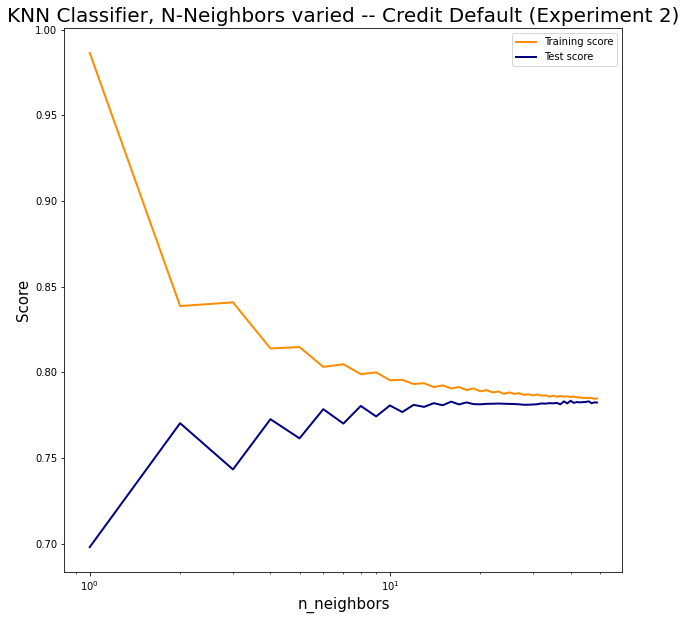

In [275]:
knn_classifier2 = KNeighborsClassifier(n_neighbors=20, weights='uniform', n_jobs=24)
knn2_stats = train_and_get_stats(knn_classifier2, X_train2, Y_train2, X_test2, Y_test2)

print(knn2_stats)
plot_training_curve(
    KNeighborsClassifier(n_neighbors=20, weights='uniform'),
    "KNN Classifier -- Credit Default (Experiment 2)",
    X_train2,
    Y_train2,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)
plot_validation_curve(
    KNeighborsClassifier(weights='uniform', n_jobs=20),
    'n_neighbors',
    list(range(1, 50)),
    X_train2,
    Y_train2,
    "KNN Classifier, N-Neighbors varied -- Credit Default (Experiment 2)",
     cv=5,
    n_jobs=18
)

## Neural Network classifier

{'train_time': 2.3473377227783203, 'train_acc': 0.7601759563450081, 'test_acc': 0.7450931262006181, 'train_score_time': 0.011999368667602539, 'test_score_time': 0.007999897003173828, 'cv_scores_train': array([0.73969933, 0.76169265, 0.7497216 , 0.6795657 , 0.76886661]), 'cv_scores_test': array([0.55574113, 0.71148225, 0.72818372, 0.58187135, 0.74686717])}


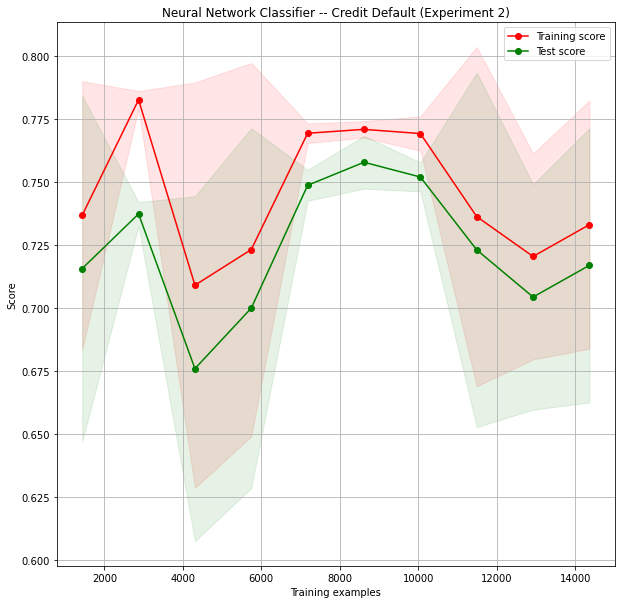

In [352]:
nn_classifier2 = MLPClassifier(hidden_layer_sizes=(100),  alpha=0.001, activation='relu', random_state=1337)
nn2_stats = train_and_get_stats(nn_classifier2, X_train2, Y_train2, X_test2, Y_test2)

print(nn2_stats)
plot_training_curve(
    MLPClassifier(hidden_layer_sizes=(100),  alpha=0.001, activation='relu', random_state=1337),
    "Neural Network Classifier -- Credit Default (Experiment 2)",
    X_train2,
    Y_train2,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)

## Boosted Decision Trees classifier

c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'train_time': 0.28099870681762695, 'train_acc': 0.8438109026115039, 'test_acc': 0.8180071828280298, 'train_score_time': 0.006999969482421875, 'test_score_time': 0.004999876022338867, 'cv_scores_train': array([0.8201559 , 0.82182628, 0.81959911, 0.81542316, 0.81425787]), 'cv_scores_test': array([0.80876827, 0.80375783, 0.81795407, 0.81996658, 0.80952381])}


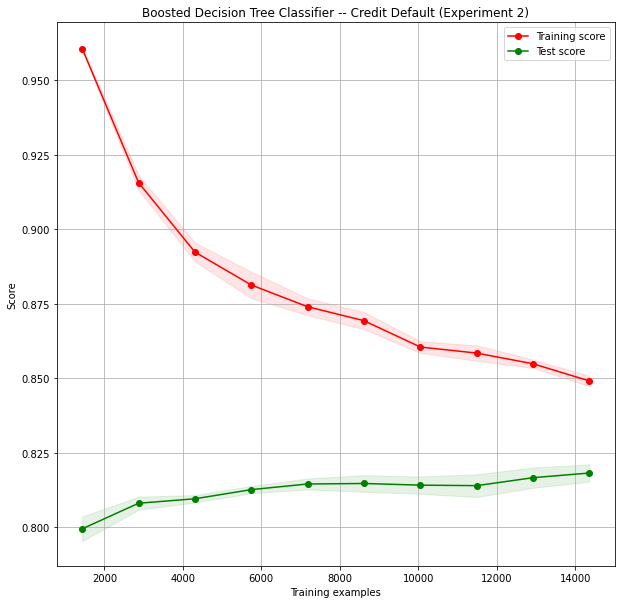

In [338]:
clf2 = xgb.XGBClassifier(n_estimators=50, max_depth=5)
clf2_stats = train_and_get_stats(clf2, X_train2, Y_train2, X_test2, Y_test2)

print(clf2_stats)
plot_training_curve(
    xgb.XGBClassifier(n_estimators=50, max_depth=5),
    "Boosted Decision Tree Classifier -- Credit Default (Experiment 2)",
    X_train2,
    Y_train2,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)

# SVCs because they are slow

## SVC Experiment 1

c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\jacob\appdata\local\program

{'train_time': 14.682016849517822, 'train_acc': 0.7820091520530696, 'test_acc': 0.7852097537006326, 'train_score_time': 0.013999462127685547, 'test_score_time': 0.008000373840332031, 'cv_scores_train': array([0.79548595, 0.79437961, 0.78562654, 0.77733415, 0.7906941 ]), 'cv_scores_test': array([0.79521032, 0.23740786, 0.78163391, 0.79883292, 0.76904177])}


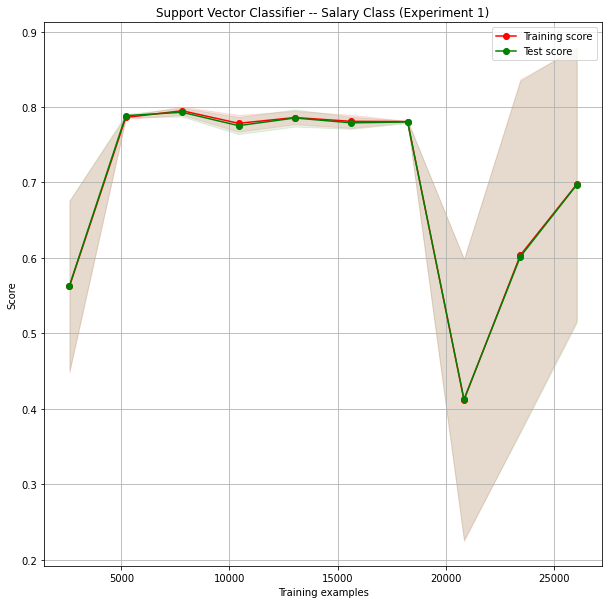

In [320]:
svc = LinearSVC(random_state=42, max_iter=10000)
svc1_stats = train_and_get_stats(svc, X_train, Y_train, X_test, Y_test)

print(svc1_stats)
plot_training_curve(
    LinearSVC(random_state=42, max_iter=10000),
    "Support Vector Classifier -- Salary Class (Experiment 1)",
    X_train,
    Y_train,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)

## SVC Experiment 2

c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


{'train_time': 9.467995643615723, 'train_acc': 0.6710284537000947, 'test_acc': 0.6639104652133968, 'train_score_time': 0.003003835678100586, 'test_score_time': 0.0029969215393066406, 'cv_scores_train': array([0.53814031, 0.68930958, 0.68847439, 0.71408686, 0.77638541]), 'cv_scores_test': array([0.69352818, 0.50521921, 0.39248434, 0.38345865, 0.71052632])}


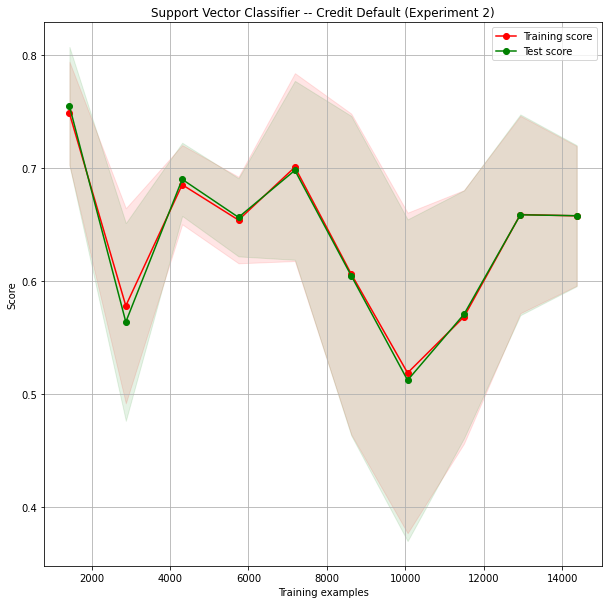

In [321]:
svc2 = LinearSVC(random_state=42, max_iter=10000)
svc2_stats = train_and_get_stats(svc2, X_train2, Y_train2, X_test2, Y_test2)

print(svc2_stats)
plot_training_curve(
    LinearSVC(random_state=42, max_iter=10000),
    "Support Vector Classifier -- Credit Default (Experiment 2)",
    X_train2,
    Y_train2,
    cv=5,
    n_jobs=18,
    fig_size=(10, 10)
)

--------
# Compare all algos after training them all

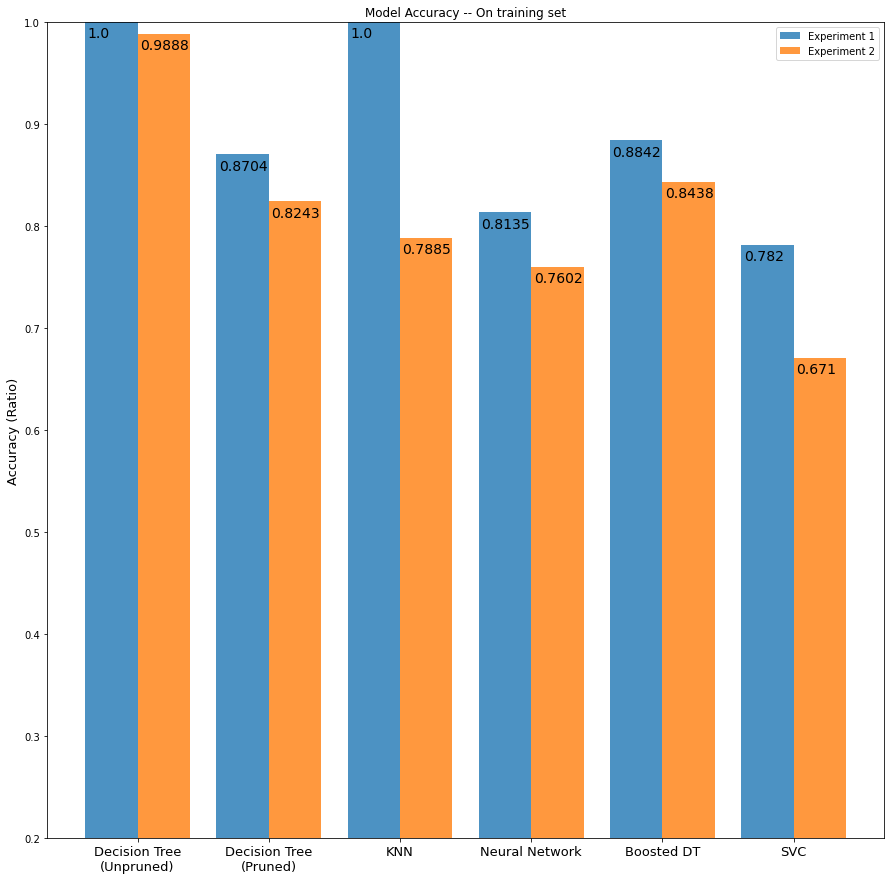

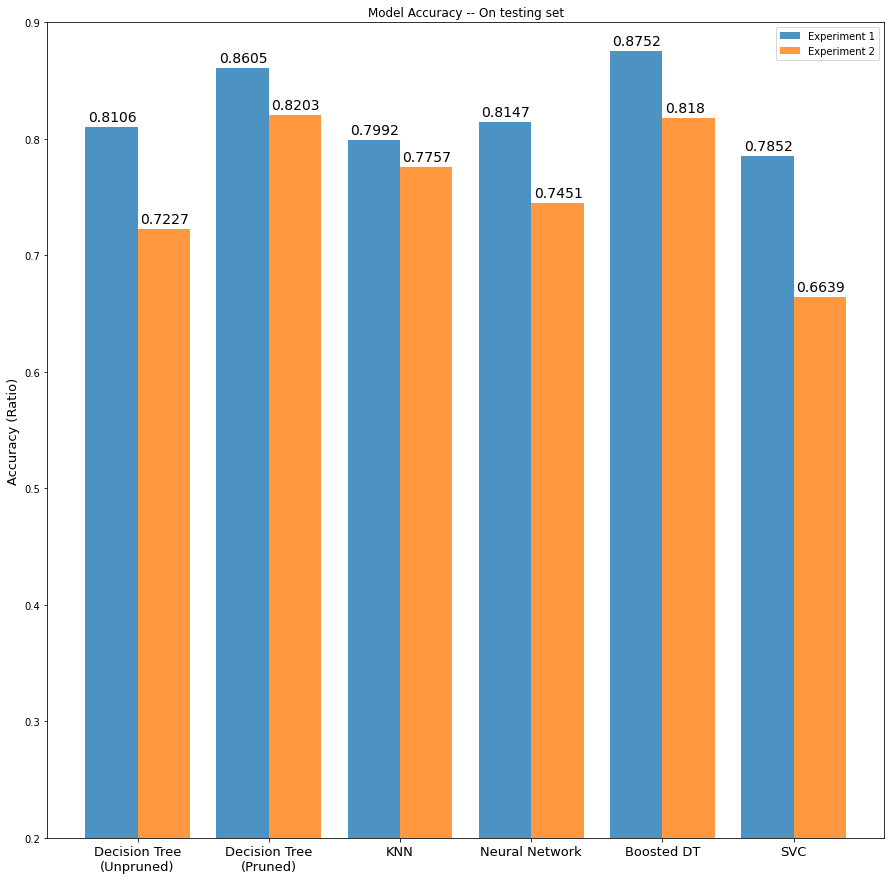

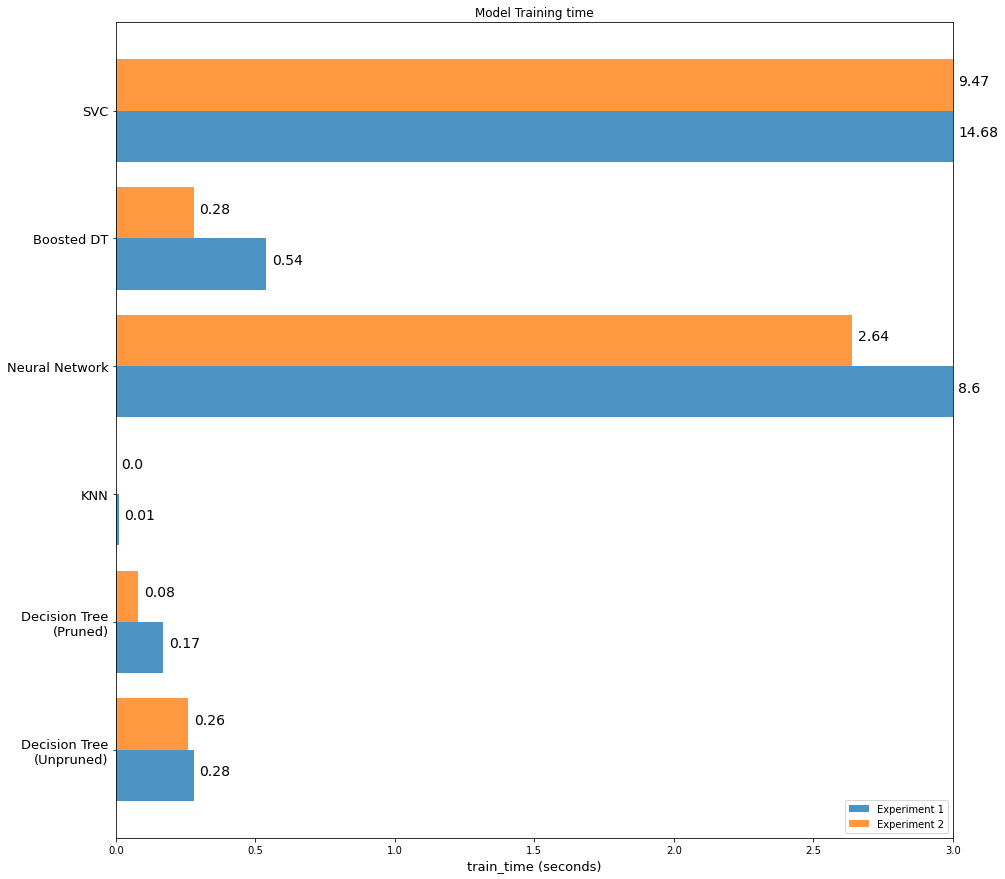

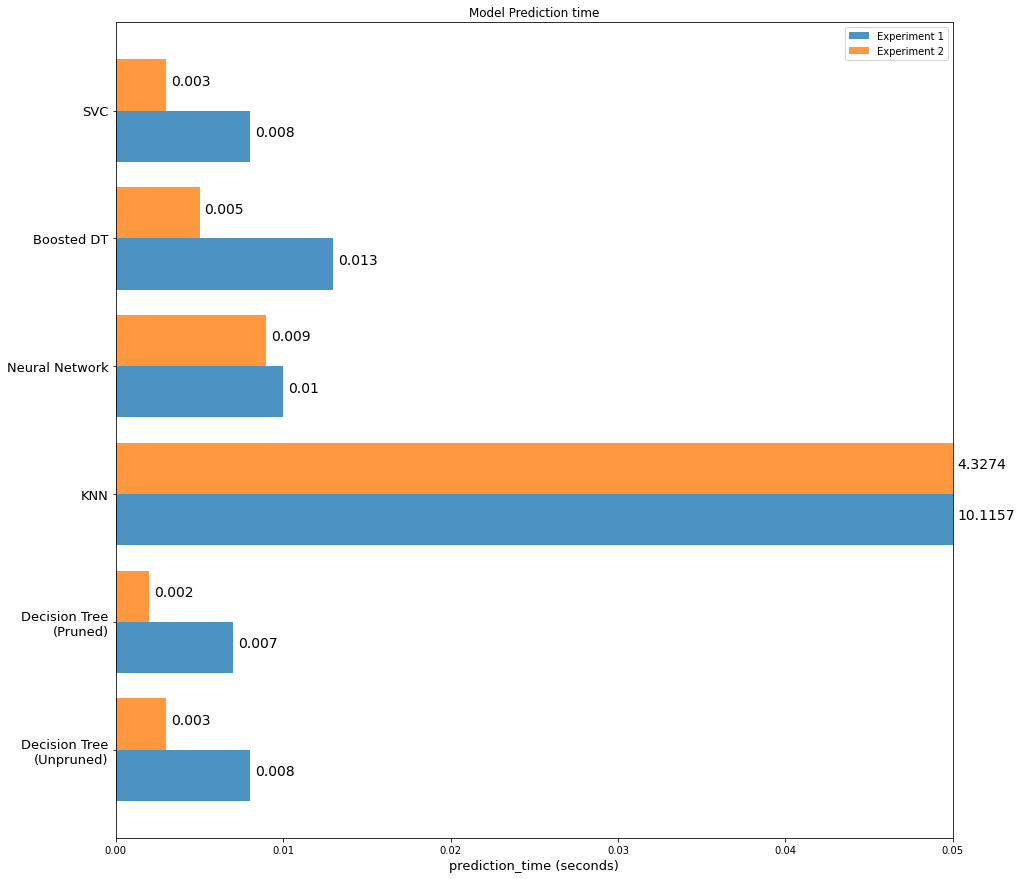

{'train_time': 0.01300048828125, 'train_acc': 0.9999692884125181, 'test_acc': 0.7991523862170629, 'train_score_time': 20.37527060508728, 'test_score_time': 10.115719556808472, 'cv_scores_train': array([0.79302933, 0.79806511, 0.79898649, 0.79791155, 0.79453317]), 'cv_scores_test': array([0.79766656, 0.79791155, 0.78593366, 0.78163391, 0.79330467])}
{'train_time': 0.0029997825622558594, 'train_acc': 0.7884626092766858, 'test_acc': 0.7757454272112253, 'train_score_time': 6.41102409362793, 'test_score_time': 4.327436208724976, 'cv_scores_train': array([0.78535635, 0.78173719, 0.78034521, 0.7814588 , 0.77777778]), 'cv_scores_test': array([0.76993737, 0.77536534, 0.77745303, 0.77443609, 0.77652464])}


In [347]:
model_stats = [ 
    dt1_Unpruned_stats,
    dt1_stats,
    dt2_Unpruned_stats,
    dt2_stats,
    knn1_stats,
    knn2_stats,
    nn1_stats,
    nn2_stats,
    clf1_stats,
    clf2_stats,
    svc1_stats,
    svc2_stats
]
exp1 = [ 
    dt1_Unpruned_stats,
    dt1_stats,
    knn1_stats,
    nn1_stats,
    clf1_stats,
    svc1_stats,
]
exp2 = [ 
    dt2_Unpruned_stats,
    dt2_stats,
    knn2_stats,
    nn2_stats,
    clf2_stats,
    svc2_stats
]

objects = ('Decision Tree\n(Unpruned)', 'Decision Tree\n(Pruned)','KNN', 'Neural Network', 'Boosted DT', 'SVC')
y_pos = np.arange(len(objects))

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['train_acc'], 4))
    performance_exp2.append(round(item2['train_acc'], 4))

plt.figure(figsize=(15, 15))
plt.ylim(0.2, 1.0)
plt.bar(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Experiment 1")
plt.bar(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Experiment 2")
plt.legend()
plt.xticks(y_pos, objects, fontsize=13)
plt.ylabel('Accuracy (Ratio)', fontsize=13)
plt.title('Model Accuracy -- On training set')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(index-0.38, value[0]-0.015, str(value[0]), fontsize=14)
    plt.text(index+0.02, value[1]-0.015, str(value[1]), fontsize=14)
plt.show()

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['test_acc'], 4))
    performance_exp2.append(round(item2['test_acc'], 4))

plt.figure(figsize=(15, 15))
plt.ylim(0.2, 0.9)
plt.bar(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Experiment 1")
plt.bar(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Experiment 2")
plt.legend()
plt.xticks(y_pos, objects, fontsize=13)
plt.ylabel('Accuracy (Ratio)', fontsize=13)
plt.title('Model Accuracy -- On testing set')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(index-0.38, value[0]+0.005, str(value[0]), fontsize=14)
    plt.text(index+0.02, value[1]+0.005, str(value[1]), fontsize=14)
plt.show()

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['train_time'], 2))
    performance_exp2.append(round(item2['train_time'], 2))

plt.figure(figsize=(15, 15))
lim=3
plt.xlim(0, lim)
plt.barh(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Experiment 1")
plt.barh(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Experiment 2")
plt.legend()
plt.yticks(y_pos, objects, fontsize=13)
plt.xlabel('train_time (seconds)', fontsize=13)
plt.title('Model Training time')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(min(value[0], lim)+0.02, index-0.2, str(value[0]), fontsize=14)
    plt.text(min(value[1], lim)+0.02, index+0.2, str(value[1]), fontsize=14)
plt.show()

###########################################

performance_exp1 = []
performance_exp2 = []
for (item1, item2) in zip(exp1, exp2):
    performance_exp1.append(round(item1['test_score_time'], 4))
    performance_exp2.append(round(item2['test_score_time'], 4))

lim=0.05
plt.figure(figsize=(15, 15))
plt.xlim(0, lim)
plt.barh(y_pos-0.2, performance_exp1, 0.4, align='center', alpha=0.8, label="Experiment 1")
plt.barh(y_pos+0.2, performance_exp2, 0.4, align='center', alpha=0.8, label="Experiment 2")
plt.legend()
plt.yticks(y_pos, objects, fontsize=13)
plt.xlabel('prediction_time (seconds)', fontsize=13)
plt.title('Model Prediction time')
for index, value in enumerate(zip(performance_exp1, performance_exp2)):
    plt.text(min(value[0], lim)+0.0003, index-0.2, str(value[0]), fontsize=14)
    plt.text(min(value[1], lim)+0.0003, index+0.2, str(value[1]), fontsize=14)
plt.show()